# Market Correlation Analysis and Prediction

This project investigates the relationship between major stock indices (DowJones, SP500, NASDAQ) and cryptocurrencies (Bitcoin, Ethereum, BinanceCoin).  
I explore their correlations, check for Granger causality, and build predictive models to see if including cryptocurrency returns improves the prediction of stock returns.

In [82]:
pip install yfinance

IMPORT LIBRARIES

In [105]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

Downloading the datasets for the same timeframe

In [106]:
#Define stock indices
indices = ['^GSPC', '^IXIC', '^DJI']  #S&P 500, NASDAQ, Dow Jones

#Download all three at once
stock_data = yf.download(indices, start='2019-01-01', end='2024-12-31', threads=False)['Close']


[*********************100%***********************]  3 of 3 completed


In [107]:
#Cryptos
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD'] #Bitcoin, Ethereum, BinanceCoin

crypto_data = yf.download(cryptos, start='2019-01-01', end='2024-12-31', threads=False)['Close']


[*********************100%***********************]  3 of 3 completed


Preprocessing Steps

In [108]:
# Merge datasets on Date
merged_data = stock_data.join(crypto_data, how='inner')

print(merged_data.head())


Ticker              ^DJI        ^GSPC        ^IXIC   BNB-USD      BTC-USD  \
Date                                                                        
2019-01-02  23346.240234  2510.030029  6665.939941  6.188613  3943.409424   
2019-01-03  22686.220703  2447.889893  6463.500000  5.903535  3836.741211   
2019-01-04  23433.160156  2531.939941  6738.859863  6.065138  3857.717529   
2019-01-07  23531.349609  2549.689941  6823.470215  6.291411  4025.248291   
2019-01-08  23787.449219  2574.409912  6897.000000  6.640054  4030.847900   

Ticker         ETH-USD  
Date                    
2019-01-02  155.047684  
2019-01-03  149.135010  
2019-01-04  154.581940  
2019-01-07  151.699219  
2019-01-08  150.359634  


In [109]:
#Merge datasets
merged_data = stock_data.join(crypto_data, how='inner')

#Remove the 'Ticker' label
merged_data.columns.name = None

print(merged_data.head())


                    ^DJI        ^GSPC        ^IXIC   BNB-USD      BTC-USD  \
Date                                                                        
2019-01-02  23346.240234  2510.030029  6665.939941  6.188613  3943.409424   
2019-01-03  22686.220703  2447.889893  6463.500000  5.903535  3836.741211   
2019-01-04  23433.160156  2531.939941  6738.859863  6.065138  3857.717529   
2019-01-07  23531.349609  2549.689941  6823.470215  6.291411  4025.248291   
2019-01-08  23787.449219  2574.409912  6897.000000  6.640054  4030.847900   

               ETH-USD  
Date                    
2019-01-02  155.047684  
2019-01-03  149.135010  
2019-01-04  154.581940  
2019-01-07  151.699219  
2019-01-08  150.359634  


In [110]:
#Rename the columns
merged_data = merged_data.rename(columns={
    '^DJI': 'DowJones',
    '^GSPC': 'SP500',
    '^IXIC': 'NASDAQ',
    'BNB-USD': 'BinanceCoin',
    'BTC-USD': 'Bitcoin',
    'ETH-USD': 'Ethereum'
})

#Check updated table
print(merged_data.head())


                DowJones        SP500       NASDAQ  BinanceCoin      Bitcoin  \
Date                                                                           
2019-01-02  23346.240234  2510.030029  6665.939941     6.188613  3943.409424   
2019-01-03  22686.220703  2447.889893  6463.500000     5.903535  3836.741211   
2019-01-04  23433.160156  2531.939941  6738.859863     6.065138  3857.717529   
2019-01-07  23531.349609  2549.689941  6823.470215     6.291411  4025.248291   
2019-01-08  23787.449219  2574.409912  6897.000000     6.640054  4030.847900   

              Ethereum  
Date                    
2019-01-02  155.047684  
2019-01-03  149.135010  
2019-01-04  154.581940  
2019-01-07  151.699219  
2019-01-08  150.359634  


In [111]:
#Check if there are any missing values
missing_values = merged_data.isna().sum()

print(missing_values)

DowJones       0
SP500          0
NASDAQ         0
BinanceCoin    0
Bitcoin        0
Ethereum       0
dtype: int64


In [112]:
#checking for duplicates

duplicates = merged_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


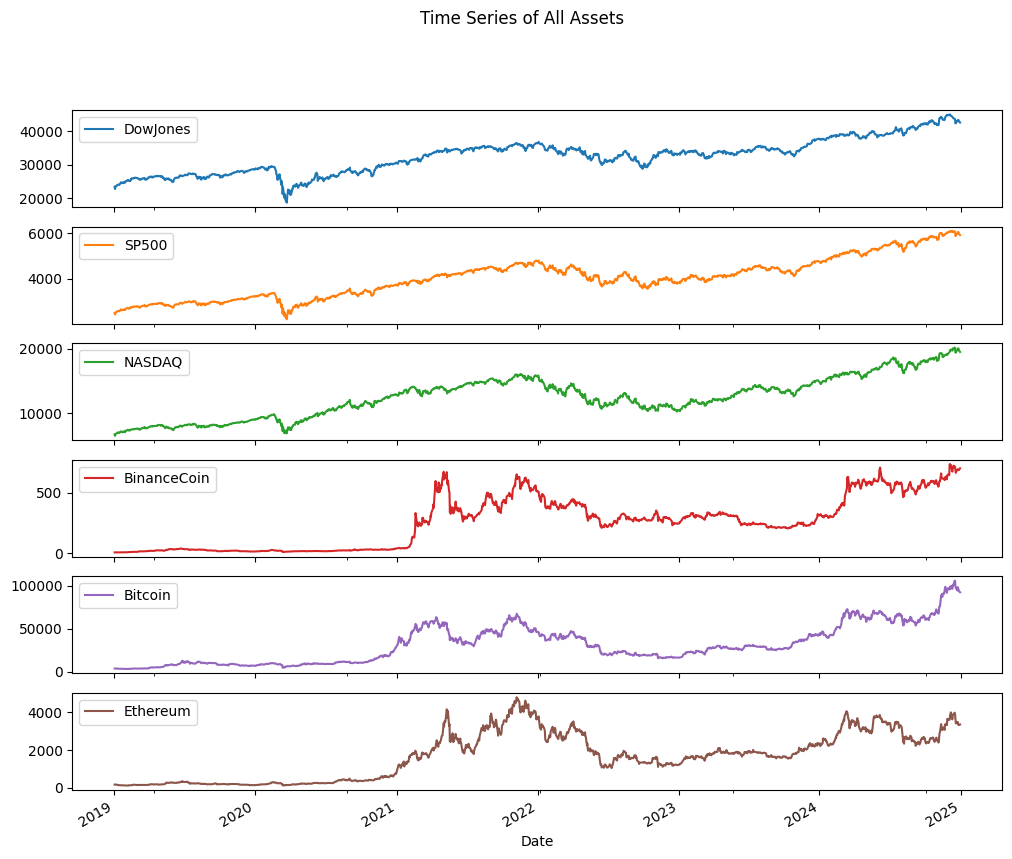

In [113]:
#outlier detection-visualization
merged_data.plot(subplots=True, figsize=(12, 10))
plt.suptitle('Time Series of All Assets')
plt.show()

In [114]:
#Stationarity Check

#ADF test on all columns
for col in merged_data.columns:
    result = adfuller(merged_data[col])
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

DowJones: ADF Statistic = -1.0121, p-value = 0.7488
SP500: ADF Statistic = -0.4175, p-value = 0.9071
NASDAQ: ADF Statistic = -0.5150, p-value = 0.8891
BinanceCoin: ADF Statistic = -1.1523, p-value = 0.6938
Bitcoin: ADF Statistic = -1.0218, p-value = 0.7452
Ethereum: ADF Statistic = -1.5017, p-value = 0.5327




*   p-value is greater than 0.05. Therefore, not stationary. Therefore, try again using the daily returns of each index and currency



In [115]:
#daily returns

returns_data = merged_data.pct_change().dropna()
print(returns_data.head())

            DowJones     SP500    NASDAQ  BinanceCoin   Bitcoin  Ethereum
Date                                                                     
2019-01-03 -0.028271 -0.024757 -0.030369    -0.046065 -0.027050 -0.038135
2019-01-04  0.032925  0.034336  0.042602     0.027374  0.005467  0.036523
2019-01-07  0.004190  0.007010  0.012556     0.037307  0.043427 -0.018648
2019-01-08  0.010883  0.009695  0.010776     0.055416  0.001391 -0.008831
2019-01-09  0.003854  0.004098  0.008711     0.000225  0.001104  0.002949


In [116]:
len(returns_data)

1508

In [117]:
#ADF test on all columns
for col in returns_data.columns:
    result = adfuller(returns_data[col])
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

DowJones: ADF Statistic = -11.8766, p-value = 0.0000
SP500: ADF Statistic = -11.7149, p-value = 0.0000
NASDAQ: ADF Statistic = -11.9642, p-value = 0.0000
BinanceCoin: ADF Statistic = -10.7316, p-value = 0.0000
Bitcoin: ADF Statistic = -40.2512, p-value = 0.0000
Ethereum: ADF Statistic = -14.1965, p-value = 0.0000




*   The daily returns dataset acheived p-values < 0.05 showing highly stationary behaviour. Therefore, it can be used from here forward.

CORRELATION ANALYSIS

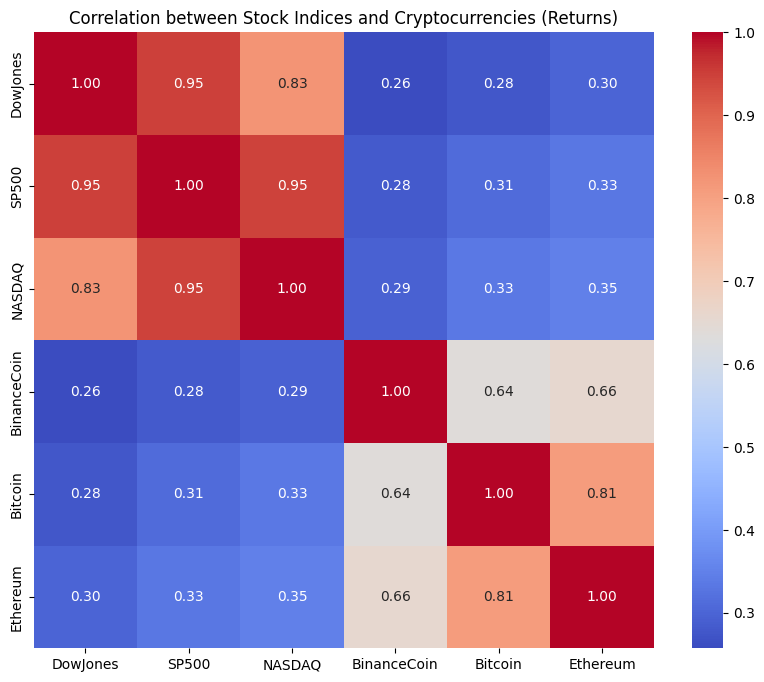

In [118]:
#Calculate correlation matrix
correlation_matrix = returns_data.corr()

#Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Stock Indices and Cryptocurrencies (Returns)')
plt.show()



*   Strong correlation can be seen within the stock indices and within the cryptocurrencies separately. But there is only a weak correlation between the markets

GRANGER CAUSALITY

In [119]:
#Define your stock and crypto columns
stocks = ['DowJones', 'SP500', 'NASDAQ']
cryptos = ['Bitcoin', 'Ethereum', 'BinanceCoin']

#Maximum number of lags to test is set to 5
max_lag = 5

#Loop through all combinations
for stock in stocks:
    for crypto in cryptos:
        #Test: Does stock lead crypto?
        print(f"\nTesting if {stock} leads {crypto}")
        result = grangercausalitytests(returns_data[[crypto, stock]], maxlag=max_lag, verbose=False)

        #For each lag, print p-value
        for lag in range(1, max_lag + 1):
            p_value = result[lag][0]['ssr_ftest'][1]
            print(f"Lag {lag} p-value: {p_value:.4f}")

        #Test: Does crypto lead stock?
        print(f"\nTesting if {crypto} leads {stock}")
        result = grangercausalitytests(returns_data[[stock, crypto]], maxlag=max_lag, verbose=False)

        for lag in range(1, max_lag + 1):
            p_value = result[lag][0]['ssr_ftest'][1]
            print(f"Lag {lag} p-value: {p_value:.4f}")



Testing if DowJones leads Bitcoin
Lag 1 p-value: 0.2048
Lag 2 p-value: 0.4559
Lag 3 p-value: 0.4978
Lag 4 p-value: 0.5997
Lag 5 p-value: 0.6322

Testing if Bitcoin leads DowJones
Lag 1 p-value: 0.3889
Lag 2 p-value: 0.0072
Lag 3 p-value: 0.0181
Lag 4 p-value: 0.0400
Lag 5 p-value: 0.0765

Testing if DowJones leads Ethereum
Lag 1 p-value: 0.3591
Lag 2 p-value: 0.2812
Lag 3 p-value: 0.4422
Lag 4 p-value: 0.5599
Lag 5 p-value: 0.4113

Testing if Ethereum leads DowJones
Lag 1 p-value: 0.7945
Lag 2 p-value: 0.0137
Lag 3 p-value: 0.0326
Lag 4 p-value: 0.0529
Lag 5 p-value: 0.0915

Testing if DowJones leads BinanceCoin
Lag 1 p-value: 0.1372
Lag 2 p-value: 0.0836
Lag 3 p-value: 0.1327
Lag 4 p-value: 0.2421
Lag 5 p-value: 0.3393

Testing if BinanceCoin leads DowJones


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

Lag 1 p-value: 0.5257
Lag 2 p-value: 0.0658
Lag 3 p-value: 0.0711
Lag 4 p-value: 0.0899
Lag 5 p-value: 0.1537

Testing if SP500 leads Bitcoin
Lag 1 p-value: 0.1409
Lag 2 p-value: 0.3615
Lag 3 p-value: 0.4290
Lag 4 p-value: 0.5583
Lag 5 p-value: 0.4557

Testing if Bitcoin leads SP500
Lag 1 p-value: 0.5571
Lag 2 p-value: 0.0462
Lag 3 p-value: 0.1053
Lag 4 p-value: 0.1746
Lag 5 p-value: 0.2781

Testing if SP500 leads Ethereum
Lag 1 p-value: 0.3038
Lag 2 p-value: 0.2563
Lag 3 p-value: 0.4121
Lag 4 p-value: 0.5009
Lag 5 p-value: 0.3191

Testing if Ethereum leads SP500


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.9014
Lag 2 p-value: 0.0627
Lag 3 p-value: 0.1277
Lag 4 p-value: 0.1635
Lag 5 p-value: 0.2719

Testing if SP500 leads BinanceCoin


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.0969
Lag 2 p-value: 0.0685
Lag 3 p-value: 0.1007
Lag 4 p-value: 0.2008
Lag 5 p-value: 0.2473

Testing if BinanceCoin leads SP500
Lag 1 p-value: 0.4063
Lag 2 p-value: 0.1744
Lag 3 p-value: 0.2194
Lag 4 p-value: 0.2683
Lag 5 p-value: 0.3932

Testing if NASDAQ leads Bitcoin


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.1738
Lag 2 p-value: 0.4192
Lag 3 p-value: 0.4510
Lag 4 p-value: 0.5757
Lag 5 p-value: 0.4372

Testing if Bitcoin leads NASDAQ


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.4931
Lag 2 p-value: 0.0770
Lag 3 p-value: 0.1615
Lag 4 p-value: 0.2727
Lag 5 p-value: 0.3683

Testing if NASDAQ leads Ethereum


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1 p-value: 0.3088
Lag 2 p-value: 0.3072
Lag 3 p-value: 0.4866
Lag 4 p-value: 0.4782
Lag 5 p-value: 0.3866

Testing if Ethereum leads NASDAQ
Lag 1 p-value: 0.8790
Lag 2 p-value: 0.1675
Lag 3 p-value: 0.2846
Lag 4 p-value: 0.4099
Lag 5 p-value: 0.4853

Testing if NASDAQ leads BinanceCoin
Lag 1 p-value: 0.1014
Lag 2 p-value: 0.1403
Lag 3 p-value: 0.1440
Lag 4 p-value: 0.2616
Lag 5 p-value: 0.2902

Testing if BinanceCoin leads NASDAQ
Lag 1 p-value: 0.2376
Lag 2 p-value: 0.1911
Lag 3 p-value: 0.3016
Lag 4 p-value: 0.3863
Lag 5 p-value: 0.4849


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


* In most cases, p-values > 0.05 → no strong Granger causality.

* But a few interesting pairs DO show potential causality!

* Some cryptos seem to lead stock indices (especially DowJones and SP500) at short lags (2, 3, 4).
* All the three cryptos lead DowJones.
* Bitcoin leads SP500 at lag 2.
* Interesting because it’s the opposite of what many people assume (that stocks lead crypto!).

* No strong evidence that stocks are leading crypto here.


Selecting **Bitcoin** and **DowJones** to see if adding Bitcoin to the train the model would improve the accuracy of the model.

* The lag is chosen as 2 because of the lowest p-value

Feature Engineering

In [120]:
#Create lagged features
data = returns_data.copy()

#DowJones lags
data['DowJones_lag1'] = data['DowJones'].shift(1)
data['DowJones_lag2'] = data['DowJones'].shift(2)

#Bitcoin lags
data['Bitcoin_lag1'] = data['Bitcoin'].shift(1)
data['Bitcoin_lag2'] = data['Bitcoin'].shift(2)

#Target variable: DowJones return at time t
data['DowJones_target'] = data['DowJones']

#Drop rows with NaN values (because of shifting)
data = data.dropna()

print(data.head())

            DowJones     SP500    NASDAQ  BinanceCoin   Bitcoin  Ethereum  \
Date                                                                        
2019-01-07  0.004190  0.007010  0.012556     0.037307  0.043427 -0.018648   
2019-01-08  0.010883  0.009695  0.010776     0.055416  0.001391 -0.008831   
2019-01-09  0.003854  0.004098  0.008711     0.000225  0.001104  0.002949   
2019-01-10  0.005143  0.004518  0.004167    -0.109256 -0.088314 -0.147065   
2019-01-11 -0.000249 -0.000146 -0.002088     0.026948  0.002294 -0.008372   

            DowJones_lag1  DowJones_lag2  Bitcoin_lag1  Bitcoin_lag2  \
Date                                                                   
2019-01-07       0.032925      -0.028271      0.005467     -0.027050   
2019-01-08       0.004190       0.032925      0.043427      0.005467   
2019-01-09       0.010883       0.004190      0.001391      0.043427   
2019-01-10       0.003854       0.010883      0.001104      0.001391   
2019-01-11       0.005143   

In [121]:
#Baseline model: Only DowJones lags
baseline_features = data[['DowJones_lag1', 'DowJones_lag2']]

#Enhanced model: DowJones lags + Bitcoin lags
enhanced_features = data[['DowJones_lag1', 'DowJones_lag2', 'Bitcoin_lag1', 'Bitcoin_lag2']]

#Target variable
target = data['DowJones_target']

In [122]:
#Baseline split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    baseline_features, target, test_size=0.2, shuffle=False)

#Enhanced split
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    enhanced_features, target, test_size=0.2, shuffle=False)


Linear Model

In [123]:
#Initialize linear regression model
lr = LinearRegression()

#Baseline Model (DowJones lags only)
#Train
lr.fit(X_train_base, y_train_base)

#Predict
y_pred_base = lr.predict(X_test_base)

#Evaluate
mse_base = mean_squared_error(y_test_base, y_pred_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)

print("Baseline Model (DowJones lags only):")
print(f"Mean Squared Error (MSE): {mse_base:.8f}")
print(f"Mean Absolute Error (MAE): {mae_base:.8f}")

#Enhanced Model (DowJones lags + Bitcoin lags)
#Train
lr.fit(X_train_enh, y_train_enh)

#Predict
y_pred_enh = lr.predict(X_test_enh)

#Evaluate
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)

print("\nEnhanced Model (DowJones + Bitcoin lags):")
print(f"Mean Squared Error (MSE): {mse_enh:.8f}")
print(f"Mean Absolute Error (MAE): {mae_enh:.8f}")


Baseline Model (DowJones lags only):
Mean Squared Error (MSE): 0.00005443
Mean Absolute Error (MAE): 0.00553094

Enhanced Model (DowJones + Bitcoin lags):
Mean Squared Error (MSE): 0.00005674
Mean Absolute Error (MAE): 0.00567429


The baseline model outperformed the enhanced model slightly showing that adding the Bitcoin prices did not significantly improve the prediction power

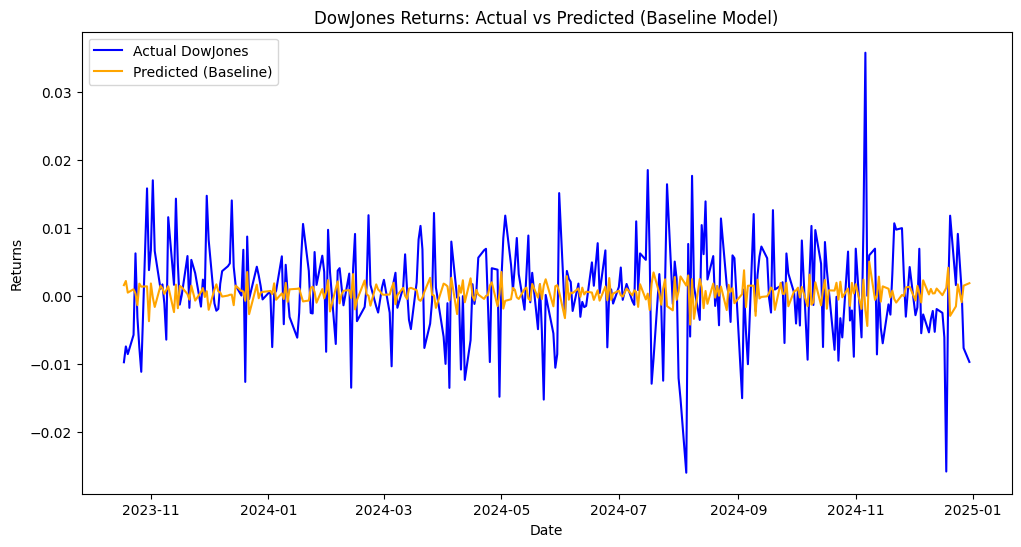

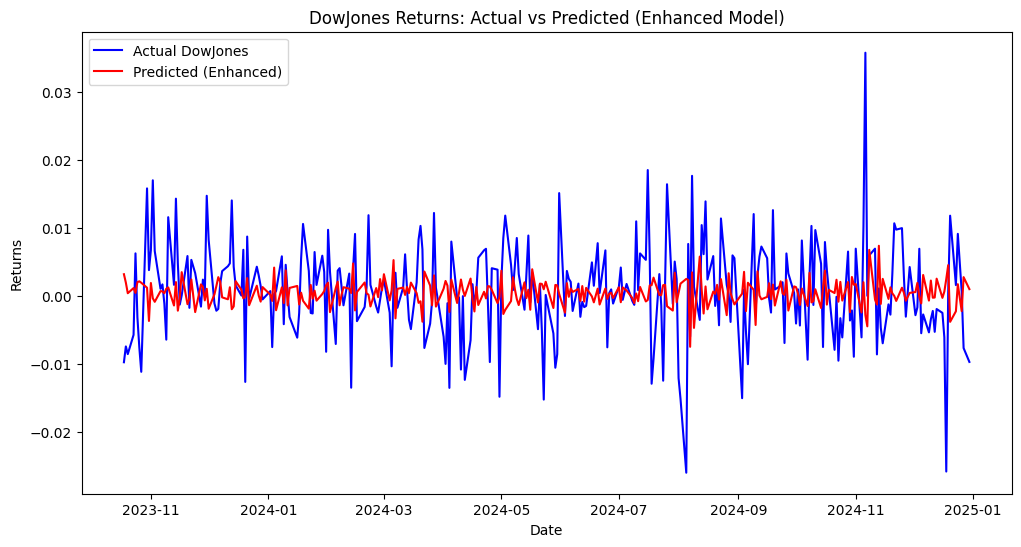

In [124]:
#Plot for Baseline model
plt.figure(figsize=(12, 6))
plt.plot(y_test_base.index, y_test_base, label='Actual DowJones', color='blue')
plt.plot(y_test_base.index, y_pred_base, label='Predicted (Baseline)', color='orange')
plt.title('DowJones Returns: Actual vs Predicted (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

#Plot for Enhanced model
plt.figure(figsize=(12, 6))
plt.plot(y_test_enh.index, y_test_enh, label='Actual DowJones', color='blue')
plt.plot(y_test_enh.index, y_pred_enh, label='Predicted (Enhanced)', color='red')
plt.title('DowJones Returns: Actual vs Predicted (Enhanced Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


It can be seen that the difference in performance is very small for the baseline and advanced models

Non-linear model: RandomForest

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Initialize linear regression model
rf = RandomForestRegressor()

#Baseline Model (DowJones lags only)
#Train
rf.fit(X_train_base, y_train_base)

#Predict
y_pred_base = rf.predict(X_test_base)

#Evaluate
mse_base = mean_squared_error(y_test_base, y_pred_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)

print("Baseline Model (DowJones lags only):")
print(f"Mean Squared Error (MSE): {mse_base:.8f}")
print(f"Mean Absolute Error (MAE): {mae_base:.8f}")

#Enhanced Model (DowJones lags + Bitcoin lags)
#Train
rf.fit(X_train_enh, y_train_enh)

#Predict
y_pred_enh = rf.predict(X_test_enh)

#Evaluate
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)

print("\nEnhanced Model (DowJones + Bitcoin lags):")
print(f"Mean Squared Error (MSE): {mse_enh:.8f}")
print(f"Mean Absolute Error (MAE): {mae_enh:.8f}")


Baseline Model (DowJones lags only):
Mean Squared Error (MSE): 0.00006703
Mean Absolute Error (MAE): 0.00624074

Enhanced Model (DowJones + Bitcoin lags):
Mean Squared Error (MSE): 0.00006209
Mean Absolute Error (MAE): 0.00599610


In the RandomForest model, the result is opposite. While the model as a whole doesn't outperform the linear model, the RF model trained with the advanced features including the Bitcoin prices outperforms the baseline RF model

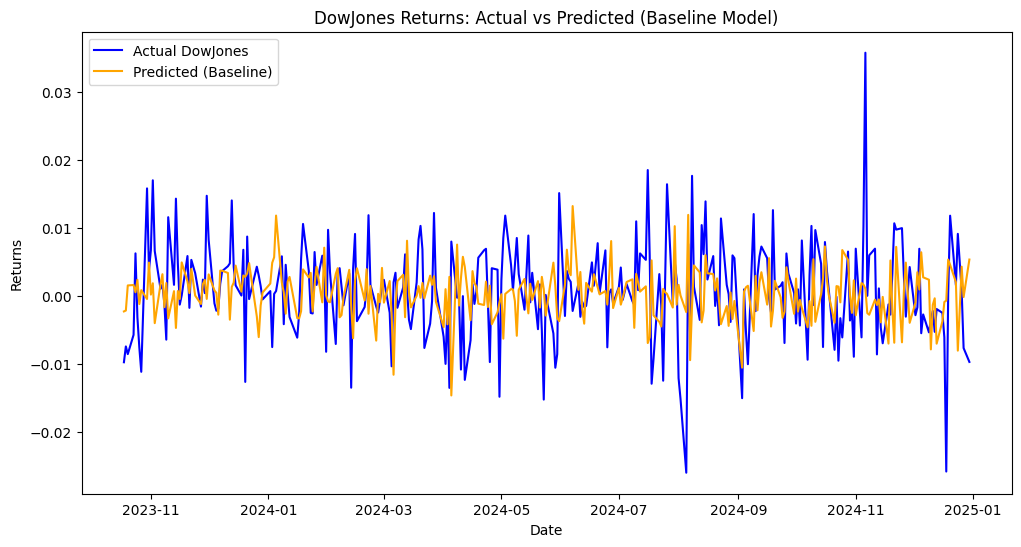

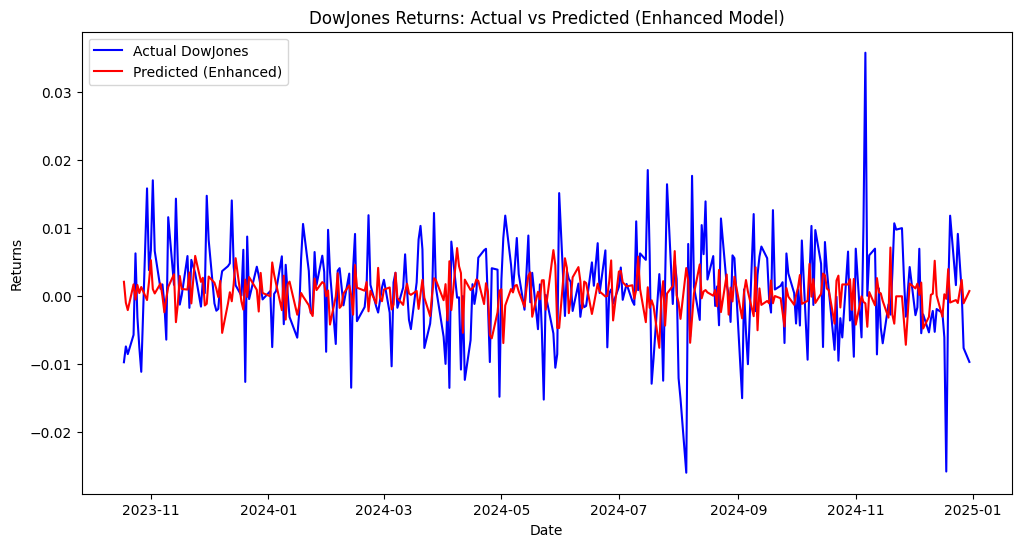

In [126]:
#Plot for Baseline model
plt.figure(figsize=(12, 6))
plt.plot(y_test_base.index, y_test_base, label='Actual DowJones', color='blue')
plt.plot(y_test_base.index, y_pred_base, label='Predicted (Baseline)', color='orange')
plt.title('DowJones Returns: Actual vs Predicted (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

#Plot for Enhanced model
plt.figure(figsize=(12, 6))
plt.plot(y_test_enh.index, y_test_enh, label='Actual DowJones', color='blue')
plt.plot(y_test_enh.index, y_pred_enh, label='Predicted (Enhanced)', color='red')
plt.title('DowJones Returns: Actual vs Predicted (Enhanced Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


Even so, the difference in the performance is still marginal between the baseline and advanced models

# Conclusion


In this project, we explored the relationship between major stock indices (DowJones, SP500, NASDAQ) and cryptocurrencies (Bitcoin, Ethereum, BinanceCoin) from 2019 to 2024.

We carried out:
- **Correlation analysis**, which showed that while stock indices are strongly correlated with each other, their correlation with cryptocurrencies is moderate to low.
- **Granger causality tests**, which indicated that some cryptocurrencies (like Bitcoin and BinanceCoin) Granger-cause DowJones returns at short lags (especially lag 2).
- **Predictive modeling**, where we compared:
  - A **baseline model** (using only past DowJones returns),
  - An **enhanced model** (using past DowJones + Bitcoin returns),
  - Using both **Linear Regression** and **Random Forest Regressor**.

**Key Findings:**
- **Linear Regression** achieved the best performance overall, and adding Bitcoin returns did not significantly improve prediction.
- **Random Forest** showed slight improvement when Bitcoin returns were included, suggesting possible non-linear relationships, but still underperformed compared to Linear Regression.

**Final Insight:**
> While statistical relationships between crypto and stock indices exist at short lags, their practical impact on improving return predictions remains limited under simple modeling approaches.

This project highlights the importance of careful testing, model comparison, and honest evaluation in financial time-series analysis.

